# Bag of Words Meets Bags of Popcorn
## Use Google's Word2Vec for movie reviews

URL: https://www.kaggle.com/competitions/word2vec-nlp-tutorial/overview

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from IPython.display import clear_output
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

## First look on data

In [2]:
data = pd.read_csv("./data/labeledTrainData.tsv.zip", delimiter="\t")

In [3]:
data.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [5]:
data.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [6]:
data.nunique()

id           25000
sentiment        2
review       24904
dtype: int64

In [7]:
data.isnull().sum()

id           0
sentiment    0
review       0
dtype: int64

Distribution of classes

<AxesSubplot:xlabel='sentiment', ylabel='count'>

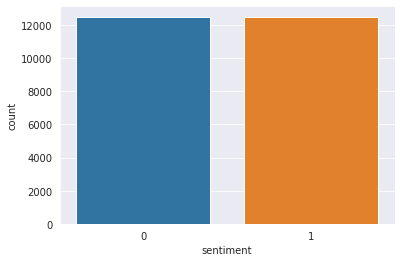

In [8]:
sns.countplot(data["sentiment"])

Length of sentences and word number distributions

<AxesSubplot:xlabel='word count', ylabel='Density'>

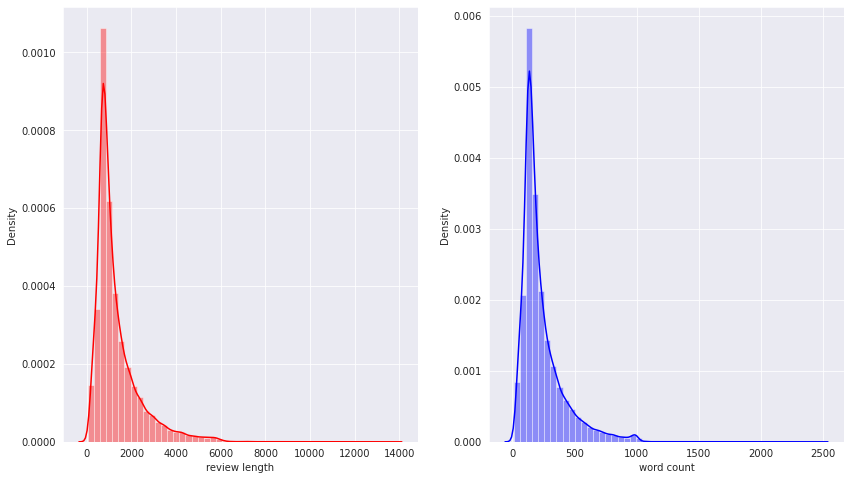

In [9]:
sentences_length = data["review"].apply(len).rename("review length")
word_count = data["review"].apply(lambda row: len(str(row).split(" "))).rename("word count")

fig=plt.figure(figsize=(14,8))
fig.add_subplot(1, 2, 1)
sns.distplot(sentences_length,color='red')
fig.add_subplot(1, 2, 2)
sns.distplot(word_count,color='blue')

In [10]:
sentences_length.describe()

count    25000.000000
mean      1327.710560
std       1005.239246
min         52.000000
25%        703.000000
50%        981.000000
75%       1617.000000
max      13708.000000
Name: review length, dtype: float64

In [11]:
word_count.describe()

count    25000.000000
mean       233.786240
std        173.745845
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
Name: word count, dtype: float64

Word cloud of uncleaned data

(-0.5, 799.5, 599.5, -0.5)

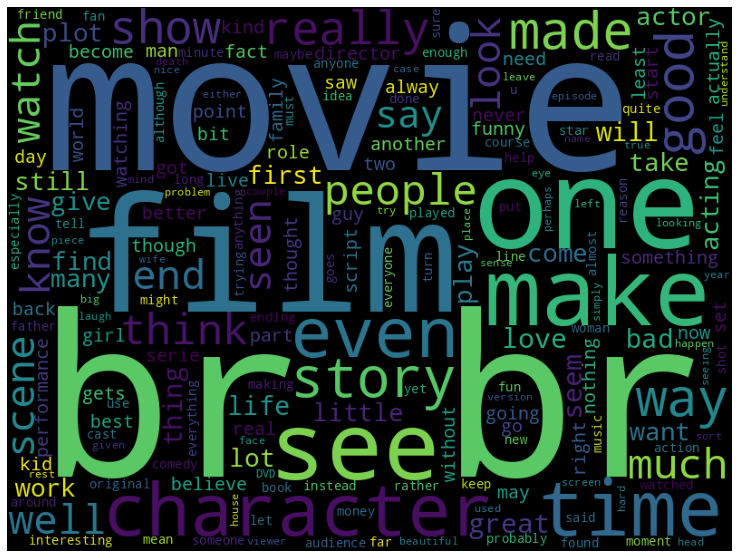

In [12]:
cloud = WordCloud(width=800, height=600, stopwords=set(STOPWORDS)).generate(" ".join(data["review"]))
plt.figure(figsize=(16,10))
plt.imshow(cloud)
plt.axis('off')

## Cleaning data

In [13]:
import re
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords


stop_words=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/dmitry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
def clean_data(string: str) -> str:
    # delete HTML-tags
    text = BeautifulSoup(string, "lxml").get_text()
    # delete no text data
    letters_only = re.sub("[^a-zA-Z]", " ", text)
    # process into lower case
    lowercase_text = letters_only.lower()
    # delete stop-words
    no_stop_words = [word for word in lowercase_text.split() if word not in stop_words]
    return " ".join(no_stop_words)

In [15]:
cleaned_data = data.copy()
cleaned_data["review"] = cleaned_data["review"].apply(clean_data)

In [16]:
cleaned_data.head()

,id,sentiment,review
0,5814_8,1,stuff going moment mj started listening music ...
1,2381_9,1,classic war worlds timothy hines entertaining ...
2,7759_3,0,film starts manager nicholas bell giving welco...
3,3630_4,0,must assumed praised film greatest filmed oper...
4,9495_8,1,superbly trashy wondrously unpretentious explo...


(-0.5, 799.5, 599.5, -0.5)

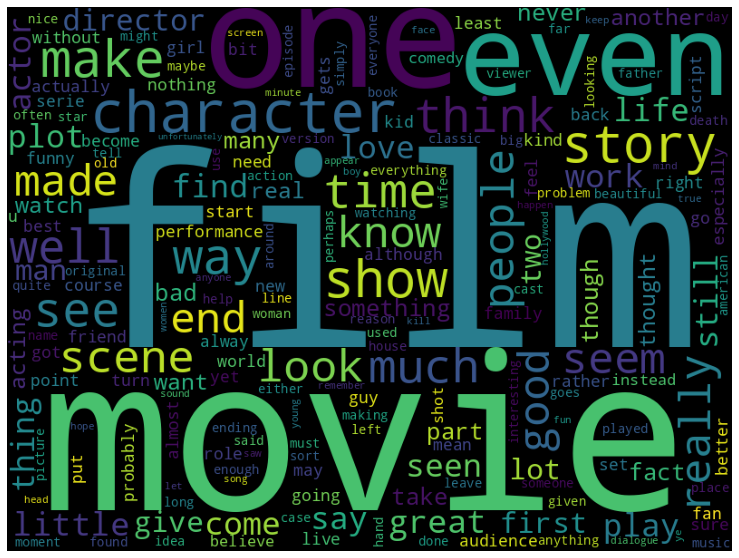

In [17]:
cloud = WordCloud(width=800, height=600, stopwords=set(STOPWORDS)).generate(" ".join(cleaned_data["review"]))
plt.figure(figsize=(16,10))
plt.imshow(cloud)
plt.axis('off')

## Deep text processing with lemmatization

In [18]:
import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download en_core_web_sm
clear_output()

In [19]:
import spacy

nlp = spacy.load("en_core_web_sm")

2022-07-17 11:27:55.057148: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-17 11:27:55.057167: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-17 11:27:56.004241: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-07-17 11:27:56.004290: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: dmitry-G5-5590
2022-07-17 11:27:56.004304: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: dmitry-G5-5590
2022-07-17 11:27:56.004426: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.129.6
2022-07-17 11:27:56.004494: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:20

In [20]:
cleaned_data["review"].apply(len).max() < nlp.max_length

True

Example

In [21]:
print("Original text:")
print(cleaned_data.iloc[0]["review"])
print("=" * 40)
print("Text after lemmatization:")
doc = nlp(cleaned_data.iloc[0]["review"])
print(" ".join([token.lemma_ for token in doc]))

Original text:
stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directo

In [22]:
def text_lemmatization(row: str) -> str:
    doc = nlp(row)
    return " ".join([token.lemma_ for token in doc])

In [23]:
lemmatization_data = cleaned_data.copy()
lemmatization_data["review"] = lemmatization_data["review"].apply(text_lemmatization)

In [24]:
lemmatization_data.head()

,id,sentiment,review
0,5814_8,1,stuff go moment mj start listen music watch od...
1,2381_9,1,classic war world timothy hine entertain film ...
2,7759_3,0,film start manager nicholas bell give welcome ...
3,3630_4,0,must assume praise film greatest film opera ev...
4,9495_8,1,superbly trashy wondrously unpretentious explo...


## Create word vectors

In [25]:
from gensim.models import Word2Vec
from multiprocessing import cpu_count
from nltk.tokenize import TreebankWordTokenizer

In [26]:
num_features = 400
embedding_dims = 128

In [27]:
sentences = []
tokenizer = TreebankWordTokenizer()

for review in tqdm(lemmatization_data["review"].to_list()):
    sentence = []
    raw_sentences = tokenizer.tokenize(str(review).rstrip())
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentence.append(raw_sentence)
    sentences.append(sentence)

100%|██████████| 25000/25000 [00:05<00:00, 4325.90it/s]


In [29]:
print(len(sentences))

25000


In [30]:
%%time
word_2_vec_model = Word2Vec(vector_size=num_features, window=5, min_count=1, workers=cpu_count())
word_2_vec_model.build_vocab(sentences)
word_2_vec_model.train(sentences, total_examples=word_2_vec_model.corpus_count, epochs=20)

CPU times: user 5min 44s, sys: 1.27 s, total: 5min 45s
Wall time: 40.1 s


(55822565, 59818900)

In [31]:
word_2_vec_model.save("word_2_vec_model")

In [32]:
word_2_vec_model = Word2Vec.load("word_2_vec_model")

In [55]:
def make_feature_vector(words: list, model: Word2Vec, size: int) -> np.array:
    feature_vector = np.zeros((size,), dtype="float32")
    for word in words:
        try:
            feature_vector = np.add(feature_vector, model.wv[str(word)])
        except KeyError:
            pass
    feature_vector = np.divide(feature_vector, len(words))
    return feature_vector


def tokenize_and_vectorize_text(rows: list, model: Word2Vec, size: int) -> np.array:
    _tokenizer = TreebankWordTokenizer()
    vectorized_data = np.zeros((len(rows), size), dtype="float32")
    for i, sample in tqdm(enumerate(rows)):
        tokens = _tokenizer.tokenize(sample)
        vectorized_data[i] = make_feature_vector(tokens, model, size)
    return vectorized_data

In [57]:
vectorize_data = tokenize_and_vectorize_text(lemmatization_data["review"].to_list(), word_2_vec_model, size=num_features)
labels = np.array(lemmatization_data["sentiment"].to_list())

25000it [00:10, 2446.28it/s]


In [58]:
print(vectorize_data.shape)
print(labels.shape)

(25000, 400)
(25000,)


## Prepare data for learning

In [59]:
X = vectorize_data
y = labels

In [60]:
from sklearn.model_selection import train_test_split


X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.33, random_state=0)

## Validate model

In [61]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_score, KFold
from catboost import CatBoostClassifier


def cross_validation(model, x_, y_, score="roc_auc") -> tuple:
    cv = KFold(n_splits=10, shuffle=True, random_state=0)
    scores = cross_val_score(model, x_, y_, scoring=score, cv=cv, n_jobs=-1, error_score="raise")
    return np.mean(scores), np.std(scores)


def plot_learning_history_nn(history) -> None:
    plt.plot(history.history["accuracy"], label="Accuracy on training data")
    plt.plot(history.history["val_accuracy"], label="Accuracy on validation data")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

def plot_roc_curve(y_pred: list, y_true: list) -> None:
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr)
    plt.axis([0,1,0,1])
    plt.title("ROC-Curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    print(f"ROC-AUC Score: {roc_auc_score(y_true, y_pred)}")


def plot_confusion_matrix(y_true: list, y_pred: list) -> None:
    cf_matrix = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cf_matrix, annot=True, cmap="Blues")
    ax.set_title("Confusion matrix")
    ax.set_xlabel("Prediction")
    ax.set_ylabel("True")
    plt.show()

### CatBoost

In [74]:
catboost = CatBoostClassifier(
    iterations=100,
    eval_metric="AUC",
)

In [75]:
print(cross_validation(catboost, X_train_val, y_train_val))

(0.9279485669869082, 0.006721783877472961)


In [79]:
catboost.fit(X_train_val, y_train_val)

Learning rate set to 0.283523
0:	total: 38.1ms	remaining: 3.77s
1:	total: 75ms	remaining: 3.67s
2:	total: 110ms	remaining: 3.56s
3:	total: 144ms	remaining: 3.45s
4:	total: 208ms	remaining: 3.94s
5:	total: 250ms	remaining: 3.91s
6:	total: 286ms	remaining: 3.81s
7:	total: 322ms	remaining: 3.7s
8:	total: 354ms	remaining: 3.58s
9:	total: 386ms	remaining: 3.47s
10:	total: 421ms	remaining: 3.41s
11:	total: 458ms	remaining: 3.36s
12:	total: 492ms	remaining: 3.29s
13:	total: 525ms	remaining: 3.22s
14:	total: 561ms	remaining: 3.18s
15:	total: 593ms	remaining: 3.11s
16:	total: 625ms	remaining: 3.05s
17:	total: 659ms	remaining: 3s
18:	total: 691ms	remaining: 2.95s
19:	total: 728ms	remaining: 2.91s
20:	total: 762ms	remaining: 2.87s
21:	total: 794ms	remaining: 2.81s
22:	total: 825ms	remaining: 2.76s
23:	total: 860ms	remaining: 2.72s
24:	total: 892ms	remaining: 2.67s
25:	total: 923ms	remaining: 2.63s
26:	total: 955ms	remaining: 2.58s
27:	total: 986ms	remaining: 2.54s
28:	total: 1.02s	remaining: 2.49

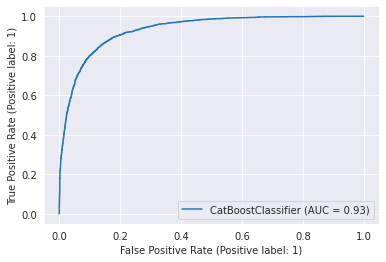

In [80]:
from sklearn import metrics

metrics.plot_roc_curve(catboost, X_test, y_test)

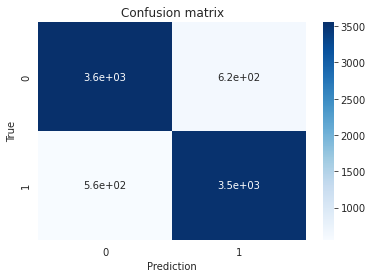

In [81]:
plot_confusion_matrix(y_test, catboost.predict(X_test))

### Neural Network

In [188]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense , LSTM , Embedding, Dropout
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Sequential


max_features = 6000
tokenizer = Tokenizer(num_words=max_features)

In [189]:
lemmatization_data["review"].apply(lambda x: len(x.split(" "))).mean()

119.63096

In [227]:
# preprocess data with keras tools


X_nn = lemmatization_data["review"].to_list()
tokenizer.fit_on_texts(X_nn)
X_nn = pad_sequences(tokenizer.texts_to_sequences(X_nn), maxlen=120)
y_nn = np.array(labels)

In [228]:
X_nn.shape

(25000, 120)

In [229]:
X_nn[:10]

array([[  18,  231,  639, ...,  983,  200, 1298],
       [   0,    0,    0, ...,  942, 4126, 4481],
       [ 246,    3,  704, ...,  698, 1113, 4006],
       ...,
       [   0,    0,    0, ...,  889,   14,  262],
       [   0,    0,    0, ...,   14,    2,   10],
       [   0,    0,    0, ...,  220,   24,  561]], dtype=int32)

In [230]:
X_train_val_nn, X_test_nn, y_train_val_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size=0.33, random_state=0)

In [231]:
X_train_val_nn.shape

(16750, 120)

In [256]:
nn_model = Sequential()
nn_model.add(Embedding(max_features, 128))
nn_model.add(Bidirectional(LSTM(32, return_sequences=True)))
nn_model.add(GlobalMaxPool1D())
nn_model.add(Dense(20, activation="relu"))
nn_model.add(Dropout(0.05))
nn_model.add(Dense(1, activation="sigmoid"))

In [257]:
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [258]:
nn_model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, None, 128)         768000    
                                                                 
 bidirectional_16 (Bidirecti  (None, None, 64)         41216     
 onal)                                                           
                                                                 
 global_max_pooling1d_16 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_34 (Dense)            (None, 20)                1300      
                                                                 
 dropout_16 (Dropout)        (None, 20)                0         
                                                                 
 dense_35 (Dense)            (None, 1)               

In [259]:
epochs = 20
batch_size = 128

In [260]:
nn_history = nn_model.fit(X_train_val_nn, y_train_val_nn, batch_size=batch_size, epochs=epochs, validation_split=0.333)

Epoch 1/20
88/88 [==============================] - 13s 122ms/step - loss: 0.5308 - accuracy: 0.7415 - val_loss: 0.3737 - val_accuracy: 0.8410
Epoch 2/20
88/88 [==============================] - 8s 95ms/step - loss: 0.2688 - accuracy: 0.8965 - val_loss: 0.3388 - val_accuracy: 0.8578
Epoch 3/20
88/88 [==============================] - 8s 93ms/step - loss: 0.1763 - accuracy: 0.9396 - val_loss: 0.3798 - val_accuracy: 0.8451
Epoch 4/20
88/88 [==============================] - 8s 93ms/step - loss: 0.1214 - accuracy: 0.9617 - val_loss: 0.4161 - val_accuracy: 0.8462
Epoch 5/20
88/88 [==============================] - 8s 93ms/step - loss: 0.0806 - accuracy: 0.9774 - val_loss: 0.5501 - val_accuracy: 0.8428
Epoch 6/20
88/88 [==============================] - 8s 87ms/step - loss: 0.0635 - accuracy: 0.9806 - val_loss: 0.5596 - val_accuracy: 0.8415
Epoch 7/20
88/88 [==============================] - 8s 91ms/step - loss: 0.0582 - accuracy: 0.9820 - val_loss: 0.5886 - val_accuracy: 0.8372
Epoch 8/20


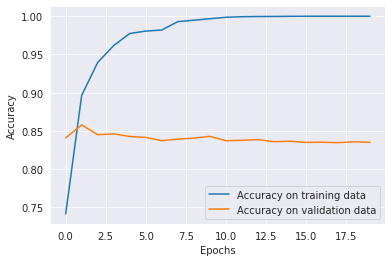

In [261]:
plot_learning_history_nn(nn_history)

In [262]:
nn_predictions =  nn_model.predict(X_test_nn)

258/258 [==============================] - 3s 8ms/step


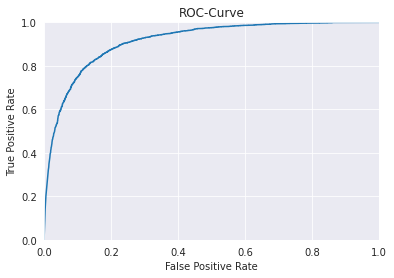

ROC-AUC Score: 0.9152117499960767


In [263]:
plot_roc_curve(nn_predictions, y_test)

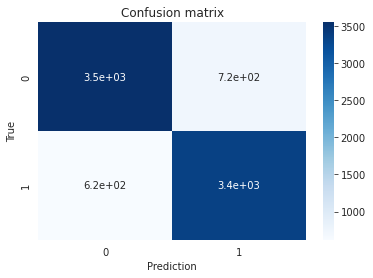

In [264]:
nn_predictions_int = [1 if pred[0] > 0.5 else 0 for pred in nn_predictions]
plot_confusion_matrix(nn_predictions_int, y_test_nn)